# Demo: Quantized Clustering of GNSS-like Trajectories (Synthetic)

This notebook creates **80 synthetic routes** belonging to **4 route types** (25, 15, 5, 35) and clusters them using `cluster_routes` from `quantized_clustering_trajectories.py`.

**Contents**
1. Generate 4 base route geometries
2. Sample noisy trajectories per type (25/15/5/35)
3. Run clustering with the provided function
4. Inspect cluster sizes and plot

**Note**: Coordinates are synthetic and expressed as latitude/longitude around a small area near `(lat, lon) ≈ (-22.0, -47.0)` just for demonstration.

In [1]:
import matplotlib.pyplot as plt
import numpy as np, math
import pandas as pd

import sys, math, random
from pathlib import Path
import itertools

# Import the provided implementation from the same folder
import quantized_clustering_trajectories as qct

print('qct functions:', [name for name in dir(qct) if name.startswith(('compare_', 'build_', 'cluster_'))])

qct functions: ['build_similarity_matrix', 'cluster_routes', 'cluster_routes_from_similarity', 'compare_routes_kdtree']


## 1) Build 4 base route types
We'll define simple shapes in lat/lon space:
- **Type A**: straight east-west line
- **Type B**: north-south line
- **Type C**: diagonal (southwest→northeast)
- **Type D**: gentle S-curve

Then we will sample noisy variants around each base (jitter and small offsets) to simulate GNSS noise and operational variation.

In [2]:
# ===== 2) ancora real (mantem igual)
LAT0, LON0 = -23.5592911, -46.6610902
rng = np.random.default_rng(42)

def deg_per_meter(lat=LAT0):
    dlat = 1.0 / 111320.0
    dlon = 1.0 / (111320.0 * math.cos(math.radians(lat)))
    return dlat, dlon

def densify_polyline(waypoints, n=220):
    pts = np.array(waypoints, dtype=float)
    if not np.allclose(pts[0], pts[-1]):
        pts = np.vstack([pts, pts[0]])  # fecha

    # comprimentos segmentares (em graus, aproximado)
    segs = pts[1:] - pts[:-1]
    seg_len = np.sqrt((segs**2).sum(axis=1))
    L = seg_len.sum()
    if L == 0:
        return pts[:,0], pts[:,1]

    # amostragem cumulativa
    t_cum = np.r_[0.0, np.cumsum(seg_len) / L]
    t = np.linspace(0, 1, n, endpoint=False)

    lat = np.interp(t, t_cum, pts[:,0])
    lon = np.interp(t, t_cum, pts[:,1])
    return lat, lon

def make_noisy_variant(lat, lon, jitter_std=1e-5, offset_std=3e-6, subsample_prob=0.1):
    lat = np.asarray(lat)
    lon = np.asarray(lon)

    # random global offset for this route
    dlat = rng.normal(0, offset_std)
    dlon = rng.normal(0, offset_std)

    # per-point jitter
    lat_noisy = lat + dlat + rng.normal(0, jitter_std, size=lat.shape)
    lon_noisy = lon + dlon + rng.normal(0, jitter_std, size=lon.shape)

    # irregular sampling: randomly drop some points
    mask = rng.random(lat_noisy.shape[0]) > subsample_prob
    lat_noisy = lat_noisy[mask]
    lon_noisy = lon_noisy[mask]

    return pd.DataFrame({"latitude": lat_noisy, "longitude": lon_noisy})

dlat_m, dlon_m = deg_per_meter(LAT0)

UP_1BLK   = 120 * dlat_m
W_1BLK    = +180 * dlon_m 

def pt(nb, wb):
    return (LAT0 + nb*UP_1BLK, LON0 + wb*W_1BLK)

S = pt(0, 0)

LOOP_A_WP = [S, pt(3, 0), pt(5, 1), pt(5, 2), pt(4, 2), pt(3, 3), pt(2, 1), pt(1, -2), pt(6, -2), pt(6, 2), pt(7, 2), pt(5, -4), pt(-1, -3), S]
LOOP_B_WP = [S, pt(3, 0), pt(5, 1), pt(5, 2), pt(2, 1), pt(1, -2), pt(6, -2), pt(6, 2), pt(7, 2), pt(5, -4), pt(-1, -3), S]
LOOP_C_WP = [S, pt(3, 0), pt(5, 1), pt(5, 2), pt(4, 2), pt(2, 1), pt(1, -2), pt(6, -2), pt(5, -4),]
LOOP_D_WP = [S, pt(3, 0), pt(1, -2), pt(6, -2), pt(6, 2), pt(-1, -3)]

bases = {}
for k, wp in zip(["A","B","C","D"], [LOOP_A_WP, LOOP_B_WP, LOOP_C_WP, LOOP_D_WP]):
    lat, lon = densify_polyline(wp, n=660)
    bases[k] = (lat, lon)
counts = {"A": 25, "B": 15, "C": 5, "D": 35}
routes, true_labels = [], []
for k, n in counts.items():
    base_lat, base_lon = bases[k]
    for _ in range(n):
        routes.append(make_noisy_variant(base_lat, base_lon))  # se quiser mais visivel: jitter_std=1e-6
        true_labels.append(k)

print("total rotas:", len(routes), "por tipo:", {k: sum(1 for t in true_labels if t==k) for k in "ABCD"})

total rotas: 80 por tipo: {'A': 25, 'B': 15, 'C': 5, 'D': 35}


## 2) Create 80 synthetic trajectories
Counts per type:
- **Type A**: 25
- **Type B**: 15
- **Type C**: 5
- **Type D**: 35

Total = 80 trajectories.

Noise model:
- Add small Gaussian jitter to each point (std ≈ 1e-5 degrees)
- Apply a tiny per-trajectory offset (mean 0, std ≈ 3e-4 degrees)
- Optionally subsample a few points to emulate irregular sampling.

In [3]:
counts = {"A": 25, "B": 15, "C": 5, "D": 35}
routes = []
true_labels = []  # A/B/C/D per route

for k, n in counts.items():
    lat, lon = bases[k]
    for _ in range(n):
        routes.append(make_noisy_variant(lat, lon))
        true_labels.append(k)

len(routes), len(true_labels), sum(counts.values())

(80, 80, 80)

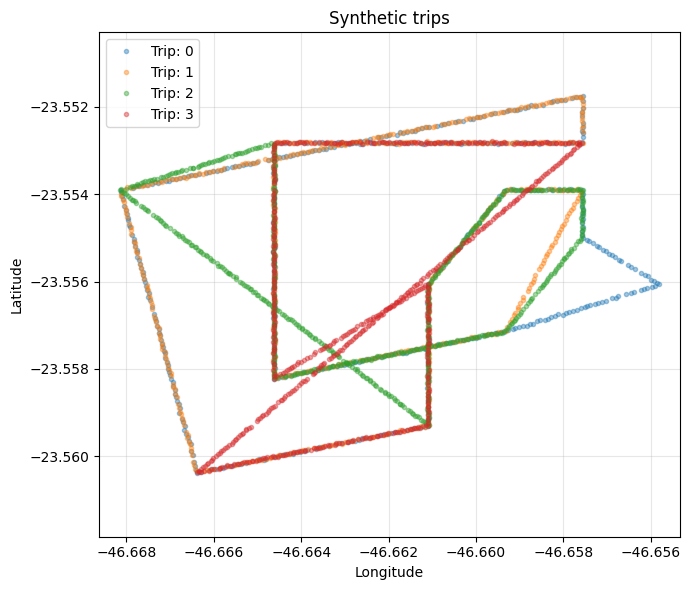

In [4]:
plt.figure(figsize=(7, 6))
for index, r in enumerate([routes[0], routes[25], routes[40], routes[45]]):
    plt.plot(r["longitude"].values, r["latitude"].values, ".", alpha=0.4, label = f"Trip: {index}")

plt.title("Synthetic trips")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, alpha=0.3)
plt.axis("equal")   # mantem escala x/y equivalente (lon/lat)
plt.legend()
plt.tight_layout()
plt.show()

## 3) Run clustering
We use:
- `truncation_deg = 0.0001` (~≈ 11 meters near the equator)
- `scale = 1000.0`
- `cut_distance = 0.04` (as in the paper/code defaults)
- `method = 'average'`

These choices should separate the four route families with small intra-group noise.

In [5]:
groups, medoids = qct.cluster_routes(
    routes=routes,
    truncation_deg=0.0001,
    lat_col="latitude",
    lon_col="longitude",
    progress=True,
    cut_distance=0.04,
    method="average"
)

for key in groups.keys():
    print(f"Index trips of group({key}): {groups[key]}")
print("\nNumber of clusters:", len(groups))
print("Cluster sizes (largest first):", [len(v) for v in groups.values()])

# Map cluster -> majority label among its members (for sanity check)
cluster_majorities = {}
for g, idxs in groups.items():
    labels = [true_labels[i] for i in idxs]
    majority = pd.Series(labels).value_counts().idxmax()
    cluster_majorities[g] = majority
cluster_majorities

Computed pairs: 3160/3160
Index trips of group(2): [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Index trips of group(4): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Index trips of group(3): [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Index trips of group(1): [40, 41, 42, 43, 44]

Number of clusters: 4
Cluster sizes (largest first): [35, 25, 15, 5]


{2: 'D', 4: 'A', 3: 'B', 1: 'C'}

## 4) Inspect results and plot
We'll print a small table with each route index, true type (A/B/C/D) and assigned cluster.

In [6]:
assignments = []
for g, idxs in groups.items():
    for i in idxs:
        assignments.append((i, true_labels[i], g))
df_assign = pd.DataFrame(assignments, columns=["route_idx", "true_type", "cluster_id"])
df_assign.sort_values(["cluster_id", "route_idx"], inplace=True)
df_assign.head(12)

,route_idx,true_type,cluster_id
75,40,C,1
76,41,C,1
77,42,C,1
78,43,C,1
79,44,C,1
0,45,D,2
1,46,D,2
2,47,D,2
3,48,D,2
4,49,D,2


### Visual check: color each route by its assigned cluster

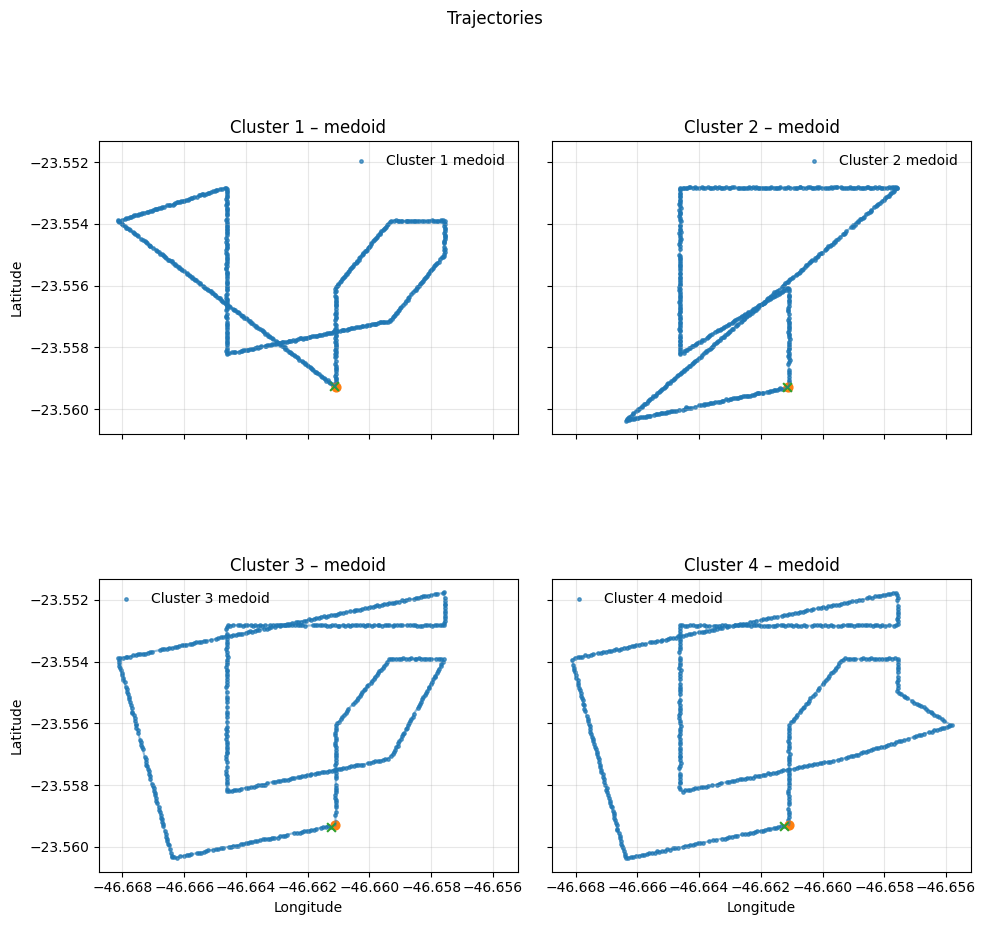

In [7]:
items = sorted(medoids.items(), key=lambda x: x[0])[:4]

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.ravel()

for ax, (g, midx) in zip(axes, items):
    r = routes[midx]
    x = r["longitude"].values
    y = r["latitude"].values

    ax.plot(x, y, alpha=0.5)
    ax.scatter(x, y, s=6, alpha=0.7, label=f"Cluster {g} medoid")

    ax.scatter(x[0],  y[0],  s=40, marker="o")  # inicio
    ax.scatter(x[-1], y[-1], s=40, marker="x")  # fim

    ax.set_title(f"Cluster {g} – medoid")
    ax.grid(True, alpha=0.3)
    ax.set_aspect("equal", adjustable="box")
    ax.legend(frameon=False, loc="best")

for ax in (axes[0], axes[2]):
    ax.set_ylabel("Latitude")
for ax in (axes[2], axes[3]):
    ax.set_xlabel("Longitude")

for k in range(len(items), 4):
    axes[k].axis("off")

fig.suptitle("Trajectories", y=0.98)
fig.tight_layout()
plt.show()

---
**Done.** You can tweak parameters like `truncation_deg`, `scale`, `cut_distance` to see how the partition changes.